In [73]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [74]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [75]:
train_df = pd.read_csv('./train.csv')
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

In [76]:
test_acc = ['NA_0','NA_-1','NA_MEAN_0','NA_MEAN_-1','NA_MODE','NA_MODE_-1']
scaling = ['Original','MinMaxScaler','StandardScaler']
model_lst = ['RF','GB']
acc = []
gb_acc = []

train_x_group = []
train_x_group.append(train_x.fillna(0))
train_x_group.append(train_x.fillna(-1))
train_x_group.append(train_x.fillna(train_x.mean().fillna(0)))
train_x_group.append(train_x.fillna(train_x.mean().fillna(-1)))
train_x_group.append(train_x.fillna(train_x.mode().loc[0].fillna(0)))
train_x_group.append(train_x.fillna(train_x.mode().loc[0].fillna(-1)))

<ipython-input-76-0fd496858fe8>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_x_group.append(train_x.fillna(train_x.mean().fillna(0)))
<ipython-input-76-0fd496858fe8>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_x_group.append(train_x.fillna(train_x.mean().fillna(-1)))


In [77]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for train_case in train_x_group:
  for i in qual_col:
      le = LabelEncoder()
      le = le.fit(train_case[i])
      train_case[i] = le.transform(train_case[i])
print('Done.')

Done.


In [78]:
for train_case in train_x_group:
  print(f'type : {type(train_case)} , Shape : {train_case.shape}')
print(f'type : {type(train_y)}, Shape : {train_y.shape}')

type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.frame.DataFrame'> , Shape : (598, 2877)
type : <class 'pandas.core.series.Series'>, Shape : (598,)


In [79]:
train_Xs = []
test_Xs = []
for train_case in train_x_group:
  train_Xs.append(train_case.loc[:499])
  test_Xs.append(train_case.loc[500:])
com_train_y = train_y[:500]
com_test_y = train_y[500:]
print(com_test_y.shape)

(98,)


In [80]:
""" Non scaled data classification"""
print("Trainig RandomForest...")
for i in tqdm(range(len(train_Xs))):
  RF = RandomForestClassifier(random_state=37).fit(train_Xs[i], com_train_y)
  y_pred = RF.predict(test_Xs[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  acc.append(score / len(y_pred) * 100)
print("Done")

print("Trainig GradientBoosting...")
for i in tqdm(range(len(train_Xs))):
  GB = GradientBoostingClassifier(random_state=37).fit(train_Xs[i], com_train_y)
  y_pred = GB.predict(test_Xs[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  gb_acc.append(score / len(y_pred) * 100)
print("Done")

100%|██████████| 6/6 [02:03<00:00, 20.59s/it]


In [81]:
""" Scaled data classification"""
scaled_train_x = []
scaled_test_x = []
print("Using MinMaxScaler...")
for i in tqdm(range(len(train_Xs))):
  mm = MinMaxScaler()
  fitted = mm.fit(train_Xs[i])
  train_mm = mm.transform(train_Xs[i])
  train_mm = pd.DataFrame(train_mm, columns = train_Xs[i].columns, index = list(train_Xs[i].index.values))
  scaled_train_x.append(train_mm)
  mm = MinMaxScaler()
  fitted = mm.fit(test_Xs[i])
  test_mm = mm.transform(test_Xs[i])
  test_mm = pd.DataFrame(test_mm, columns = test_Xs[i].columns, index = list(test_Xs[i].index.values))
  scaled_test_x.append(test_mm)
print("Done")

print("Trainig RandomForest modified by MinMaxScaler...")
for i in tqdm(range(len(scaled_train_x))):
  RF = RandomForestClassifier(random_state=37).fit(scaled_train_x[i], com_train_y)
  y_pred = RF.predict(scaled_test_x[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  acc.append(score / len(y_pred) * 100)
print("Done")

print("Trainig Gradient Boosting modified by MinMaxScaler...")
for i in tqdm(range(len(scaled_train_x))):
  GB = GradientBoostingClassifier(random_state=37).fit(scaled_train_x[i], com_train_y)
  y_pred = GB.predict(scaled_test_x[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  gb_acc.append(score / len(y_pred) * 100)
print("Done")

Trainig Original modified by MinMaxScaler...


100%|██████████| 6/6 [00:00<00:00, 13.48it/s]


Trainig RandomForest modified by MinMaxScaler...


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Trainig Gradient Boosting modified by MinMaxScaler...


100%|██████████| 6/6 [01:45<00:00, 17.54s/it]


In [82]:
""" Standard Scaled data classification"""
scaled_train_x = []
scaled_test_x = []
print("Using StandardScaler...")
for i in tqdm(range(len(train_Xs))):
  mm = StandardScaler()
  fitted = mm.fit(train_Xs[i])
  train_mm = mm.transform(train_Xs[i])
  train_mm = pd.DataFrame(train_mm, columns = train_Xs[i].columns, index = list(train_Xs[i].index.values))
  scaled_train_x.append(train_mm)
  mm = StandardScaler()
  fitted = mm.fit(test_Xs[i])
  test_mm = mm.transform(test_Xs[i])
  test_mm = pd.DataFrame(test_mm, columns = test_Xs[i].columns, index = list(test_Xs[i].index.values))
  scaled_test_x.append(test_mm)
print("Done")

print("Trainig RandomForest modified by StandardScaler...")
for i in tqdm(range(len(scaled_train_x))):
  RF = RandomForestClassifier(random_state=37).fit(scaled_train_x[i], com_train_y)
  y_pred = RF.predict(scaled_test_x[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  acc.append(score / len(y_pred) * 100)
print("Done")

print("Trainig GradientBoosting modified by StandardScaler...")
for i in tqdm(range(len(scaled_train_x))):
  GB = GradientBoostingClassifier(random_state=37).fit(scaled_train_x[i], com_train_y)
  y_pred = GB.predict(scaled_test_x[i])
  score = 0
  tmp_test_np = com_test_y.values
  for i in range(len(y_pred)):
    if y_pred[i] == tmp_test_np[i]:
      score = score + 1
  gb_acc.append(score / len(y_pred) * 100)
print("Done")

Trainig Original modified by StandardScaler...


100%|██████████| 6/6 [00:00<00:00, 14.60it/s]


Trainig RandomForest modified by StandardScaler...


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Trainig GradientBoosting modified by StandardScaler...


100%|██████████| 6/6 [01:55<00:00, 19.32s/it]


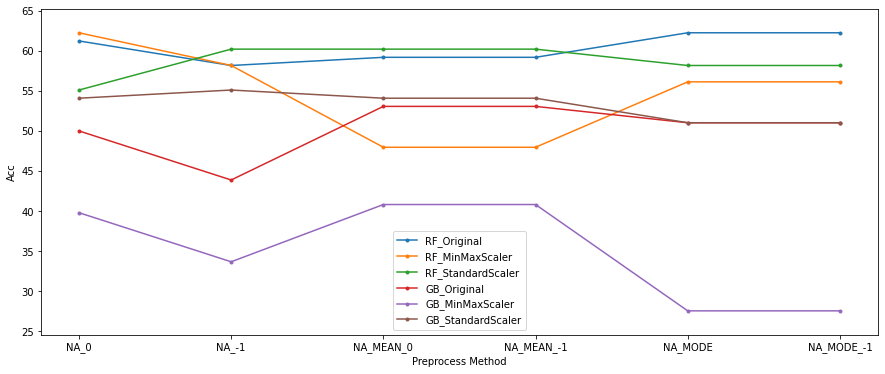

In [83]:
plt.figure(figsize = (15,6))
for i in range(len(scaling)):
  plt.plot(range(len(acc) // len(scaling)), np.array(acc)[len(acc)//len(scaling) * i:len(acc)// len(scaling) * (i+1)], marker = ".", label = f'RF_{scaling[i]}')
for i in range(len(scaling)):
  plt.plot(range(len(gb_acc) // len(scaling)), np.array(gb_acc)[len(gb_acc)//len(scaling) * i:len(gb_acc)// len(scaling) * (i+1)], marker = ".", label = f'GB_{scaling[i]}')

plt.ylim(min(acc + gb_acc)-3, max(acc+gb_acc)+3)
plt.xticks(range(len(acc)//len(scaling)),test_acc)
plt.xlabel('Preprocess Method')
plt.ylabel('Acc')
plt.legend()
plt.show()

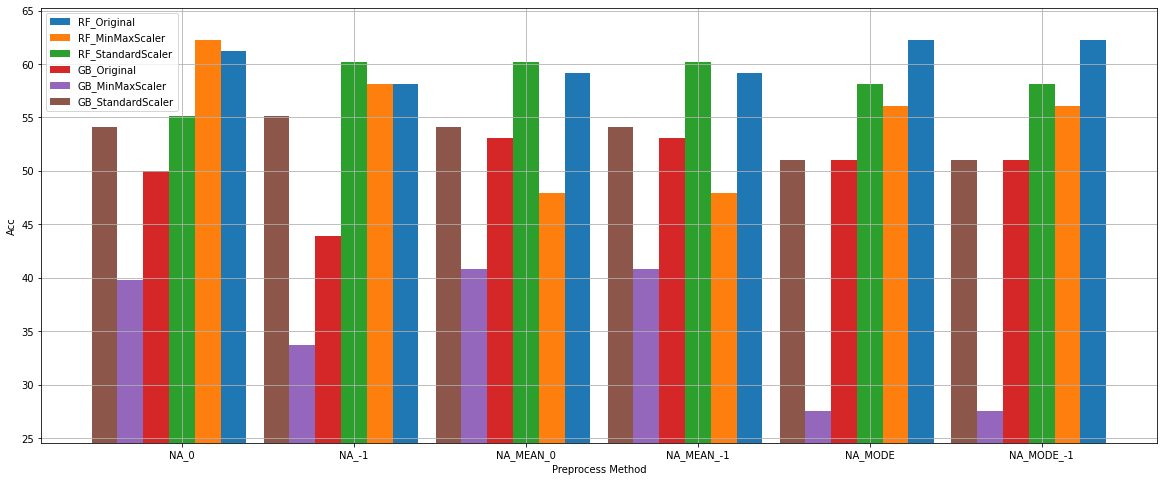

In [88]:
plt.figure(figsize = (20,8))
index = np.arange(len(test_acc))
total_acc = acc + gb_acc
total_acc_np = np.array(total_acc).reshape(-1,6)
total_acc_df = pd.DataFrame(total_acc_np, columns = test_acc, index = np.arange(6))

w = 0.15
for i,k in enumerate(test_acc):
  plt.bar(index - ((-2 + i)* w), total_acc_df.loc[i], width = w, label = f'{model_lst[i//3]}_{scaling[i%len(scaling)]}')
plt.xticks(range(len(test_acc)),test_acc)
plt.xlabel('Preprocess Method')
plt.ylabel('Acc')
plt.ylim(min(total_acc)-3, max(total_acc) + 3)
plt.legend()
plt.grid()
plt.show()